In [21]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers    
from keras.utils import to_categorical
from keras import optimizers


In [2]:
# veri önce karıştırılıyor (shuffle) sonra da eğitim/test diye ayrılıyor
# Veri karıştırılır ve train-test şeklinde bölünüyor

(x_train,y_train),(x_test,y_test) = cifar100.load_data() 

In [3]:
# ödev için belirlenen sınıflarımızı Cifar100 veri seti içinden 'siniflarim' isminde değişkenin içine ayırıp yerleştiriyoruz

siniflarim = dict({0:"apple",3:"bear",44:"lizard",59:"pine_tree",89:"tractor",91:"trout"})

In [4]:
def save_resimler(x,y,siniflar,dosya_yol):
    for i,j in siniflar.items():
        sinif_yol = os.path.join(dosya_yol, j)
        os.mkdir(sinif_yol)
        resimler = x[y[:,0] == i]
        for k,resim in enumerate(resimler):
            plt.imsave(sinif_yol +"\\"+ str(k)+".png",resim)   

In [5]:
veriseti_path = "cifar100_siniflar"

os.mkdir(veriseti_path)

train_dir = os.path.join(veriseti_path, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(veriseti_path, 'test')
os.mkdir(test_dir)

save_resimler(x_train,y_train,siniflarim,train_dir)
save_resimler(x_test,y_test,siniflarim,test_dir)

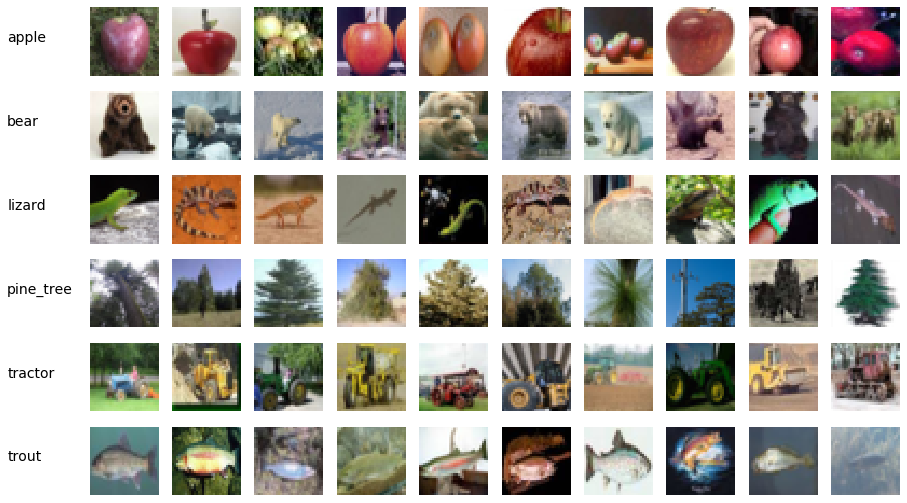

In [6]:
# plt olarak import ettiğimiz matplotlib.pyplot kütüphane ile eğitim için kullandığımız sınıfların örnek görüntüsünü alıyoruz

fig,ax = plt.subplots(6,11,figsize=(16,9))

labels = list(siniflarim.keys())

for i in range(6):
    resimler = x_train[y_train[:,0] == labels[i]]
    ax[i,0].axis("off")
    ax[i,0].text(0,0.5,siniflarim[labels[i]],fontdict={"size":14})
    for j in range(1,11):
        ax[i,j].axis("off")
        ax[i,j].imshow(resimler[j])
        
plt.show()

In [7]:
# Parametrelerin eğitilmesi :
epochs = 30                    # 30 epoch ile eğitim yapılacaktır.
batch_size = 50                # Her iterasyonda 50 fotoğraf alınır.
sinif_sayisi = len(siniflarim) # veri setinde 6  sınıf bulunmaktaonu len fonksiyon ile alıyoruz.
kanal_sayisi = x_train.shape[3]
genislik = x_train.shape[1]
uzunluk = x_train.shape[2]
 
# Modelin kaydedileceği yer belirlenir
save_dir = os.path.join(os.getcwd(), 'saved_models') 

# Kaydedilecek modelin dosya adı belirlenir
model_name = 'keras_6_classes_from_cifar100_trained_model.h5' 

In [23]:
# Verinin kesirli hale getirilip normalleştirilmesi
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [28]:
# Modelin temelinin oluşturulması
def make_model(dropout=False):
    model = models.Sequential() 
    
    # 32 adet 3x3 boyutunda filtereler oluşturulur ve modele eklenir
    # "Padding" fotoğrafa çervçeve ekler ve çıkış boyutunun giriş boyutuna eşit olması sağlanır
    # ReLu aktivasyon fonksiyonumuzu eklenir
    
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",
                            input_shape=(genislik,uzunluk,kanal_sayisi)))
    # 32 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
    
    #1. evrişimden sonra max poolig metodunu kullanmaktadır.max pooling ile doğruluk oranı 87%'ye kadar çıkıyor.
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 16 x 16 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 64 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 8 x 8 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 128 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    # Cifar10 veri setinin resimleri max pool metodunu kullanmak için çok küçük(32x32). Bu nedenle:
    # pool_size=3, strides=2, padding='same' yapıyoruz
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 4 x 4 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 2 boyutlu görsellerimizi 1 boyutlu vektöre çeviriyoruz
    model.add(layers.Flatten())
    # Dropout uygulanacak ise :
    if(dropout):
        
        # Rastgele olacak şekilde nöronların %50'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için)
        model.add(layers.Dropout(0.5))
        
    # 256 nöronumuzu modelimize ve ReLu aktivasyon fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(256,activation="relu"))
    
    # 6 sınıfımızı temsil edecek 6 nöronumuzu modelimize ekliyoruz:(sinif_sayisi= 6)
    # Çıkış katmanına Sınıfların olasılıklarını hesaplamak için :
    # sınıf sayısı kadar "Softmax" aktivasyonlu nöron fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(sinif_sayisi,activation="softmax"))
    
    # Modeli eğitirken kullanacağımız optimizasyon ve hata hesaplama fonksiyonumuzu belirliyoruz
    # "RMSprop" optimizasyon fonksiyonumuzu hazırlıyoruz: (lr=0.0001, decay=1e-6)
    # Sınıflandırma yapacağımız için "categorical_crossentropy" fonksiyonunu kullanıyoruz
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss="categorical_crossentropy",metrics=["acc"])
    model.summary()
    
    return model

In [26]:
def make_generator(train_dir,test_dir,augmentation=False):
    
    # Veri çeşitliliğini artırmak için veri sentezi (data augmentation)
    # Ön işleme ve gerçek zamanlı veri arttırımının uygulanması yapılacak ise:
    
    if(augmentation):
        
        print('Using real-time data augmentation.')
        
        # Sentezlenmiş (döndürülmüş, ters çevrilmiş, yakınlaştırolmış vb.) resimler üretmek için ImageDataGenerator kullanıyorum  
        # Canlı veri arttırmak için ayarlarımalar:
        
        train_datagen = image.ImageDataGenerator(rescale=1./255,                                          
        featurewise_center=False,             # Giriş verilerinin prtalamasının 0'lanması
        samplewise_center=False,              # Herbir örnek verinin ortalamasının 0'a eşitlenmesi
        featurewise_std_normalization=False,  # Giriş verilerinin, veri setinin standart varyans değerine bölünmesi
        samplewise_std_normalization=False,   # Herbir verinin standart varyans değerine bölünmesi
        zca_whitening=False,                  # "ZCA whitening" metodunun uygulanması                 
        rotation_range=0,                     # Resimlerin bir sınır aralığında gelişi güzel döndürülmesi (degrees, 0 to 180)
        width_shift_range=0.1,                # Görüntüleri rasgele olarak yatay olarak kaydırılır
        height_shift_range=0.1,               # Görüntüleri rasgele olarak dikey olarak kaydırılır
        shear_range=0.15,                     # Görüntüleri üzerinde rasgele makaslama
        zoom_range=0.15,                      # Görüntüleri üzerinde rasgele yakınlaştırılıyor
        horizontal_flip=True,                 # Fotoğrafı yatay düzlemde rastgele çevirme.
        vertical_flip=False)                  # Resimlerin gelişigüzel bir şekilde dikey olarak çevirilmesi
        
    
    # Veri arttırma işlemi yapılmayacak ise: 
    
    else: 
        print('Not using data augmentation.')
        
        train_datagen = image.ImageDataGenerator(rescale=1./255)
     
    test_datagen = image.ImageDataGenerator(rescale=1/255.)
    
    # Fit the model on the batches generated by datagen.flow().
    # Sınıf vektörlerinin ikili sınıf matrislerine dönüştürülmesi (categorical)
    
    train_gen = train_datagen.flow_from_directory(train_dir,target_size=(genislik,uzunluk),
                                              class_mode="categorical",batch_size=batch_size)
    test_gen = test_datagen.flow_from_directory(test_dir,target_size=(genislik,uzunluk),
                                              class_mode="categorical",batch_size=batch_size)
    
    return train_gen,test_gen

In [10]:
def make_gorsel(history,suptitle):
    epoklar = range(1,len(history["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    axx[0].plot(epoklar,history["loss"],label="Training Loss")
    axx[0].plot(epoklar,history["val_loss"],label="Validation Loss")
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    axx[1].plot(epoklar,history["acc"],label="Training Accuracy")
    axx[1].plot(epoklar,history["val_acc"],label="Validation Accuracy")
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle(suptitle,fontsize=15,color="black")

    plt.show()

In [73]:
def make_gorsel_2(historyList,aciklamalar):
    epoklar = range(1,len(historyList[0]["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    colors = ["red","green","grey"]
    
    for i,history in enumerate(historyList):
        axx[0].plot(epoklar,history["loss"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[0].plot(epoklar,history["val_loss"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
        
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    for i,history in enumerate(historyList):
        axx[1].plot(epoklar,history["acc"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[1].plot(epoklar,history["val_acc"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle("-".join(aciklamalar) + " Karşılaştırılması",fontsize=15,color="red")

    plt.show()

In [32]:
# Eğitim ve test için : kayıp ve doğruluk
def make_gorsel_3(history):
    plt.figure(0)
    plt.plot(history.history['acc'],'r')
    plt.plot(history.history['val_acc'],'g')
    plt.xticks(np.arange(0, 11, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.xticks(np.arange(0, 11, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    
    

In [12]:
train_gen,test_gen = make_generator(train_dir,test_dir)

Not using data augmentation.
Found 3000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [13]:
model = make_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

In [14]:
#Dropout ve Veri Augmentation yapılmadan modelimizi eğitiyoruz

historyNormal = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/30
60/60 [==============================] - 428s 7s/step - loss: 1.6466 - acc: 0.3403 - val_loss: 1.3818 - val_acc: 0.3767
Epoch 2/30
60/60 [==============================] - 380s 6s/step - loss: 1.3001 - acc: 0.4873 - val_loss: 1.3906 - val_acc: 0.4783
Epoch 3/30
60/60 [==============================] - 351s 6s/step - loss: 1.1851 - acc: 0.5253 - val_loss: 1.2136 - val_acc: 0.5650
Epoch 4/30
60/60 [==============================] - 325s 5s/step - loss: 1.1277 - acc: 0.5620 - val_loss: 0.9123 - val_acc: 0.5950
Epoch 5/30
60/60 [==============================] - 345s 6s/step - loss: 1.0561 - acc: 0.5917 - val_loss: 1.0906 - val_acc: 0.5733
Epoch 6/30
60/60 [==============================] - 273s 5s/step - loss: 1.0090 - acc: 0.6177 - val_loss: 0.9117 - val_acc: 0.6500
Epoch 7/30
60/60 [==============================] - 320s 5s/step - loss: 0.9753 - acc: 0.6243 - val_loss: 0.9720 - val_acc: 0.6183
Epoch 8/30
60/60 [==============================] - 273s 5s/step - loss: 0.9305 - a

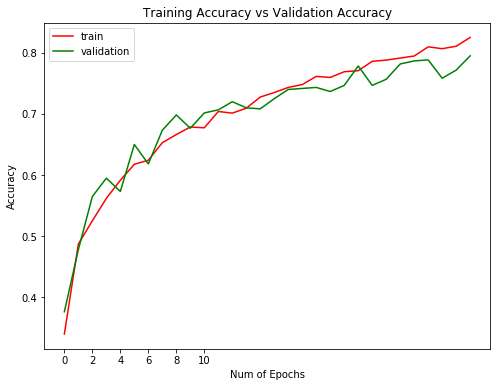

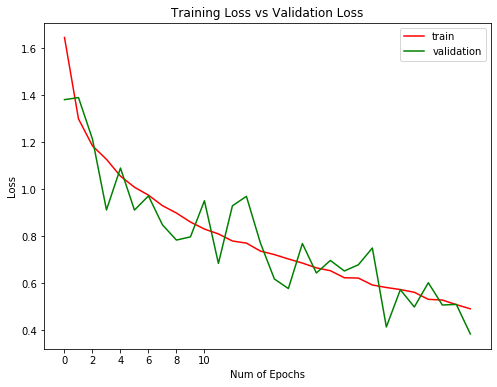

In [40]:
make_gorsel_3(historyNormal)

In [29]:
model = make_model(dropout=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)        

In [30]:
# Canlı olarak arttırılan veri ile modelimizi eğitelim:

Dropout_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/30
60/60 [==============================] - 361s 6s/step - loss: 1.6485 - acc: 0.3280 - val_loss: 1.4094 - val_acc: 0.4450
Epoch 2/30
60/60 [==============================] - 365s 6s/step - loss: 1.3653 - acc: 0.4560 - val_loss: 1.1834 - val_acc: 0.5067
Epoch 3/30
60/60 [==============================] - 483s 8s/step - loss: 1.2348 - acc: 0.5093 - val_loss: 1.0670 - val_acc: 0.5433
Epoch 4/30
60/60 [==============================] - 461s 8s/step - loss: 1.1874 - acc: 0.5417 - val_loss: 1.0551 - val_acc: 0.6017
Epoch 5/30
60/60 [==============================] - 486s 8s/step - loss: 1.1293 - acc: 0.5643 - val_loss: 0.8352 - val_acc: 0.6467
Epoch 6/30
60/60 [==============================] - 354s 6s/step - loss: 1.0728 - acc: 0.6007 - val_loss: 1.0169 - val_acc: 0.6317
Epoch 7/30
60/60 [==============================] - 479s 8s/step - loss: 1.0411 - acc: 0.6087 - val_loss: 0.7706 - val_acc: 0.6333
Epoch 8/30
60/60 [==============================] - 472s 8s/step - loss: 0.9912 - a

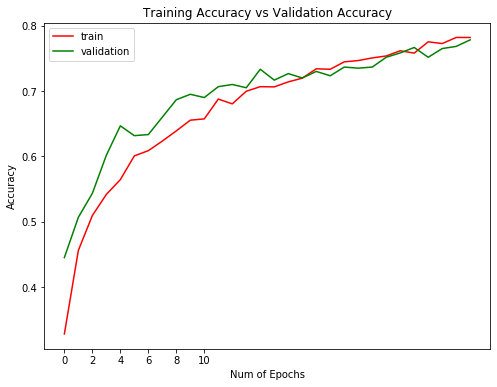

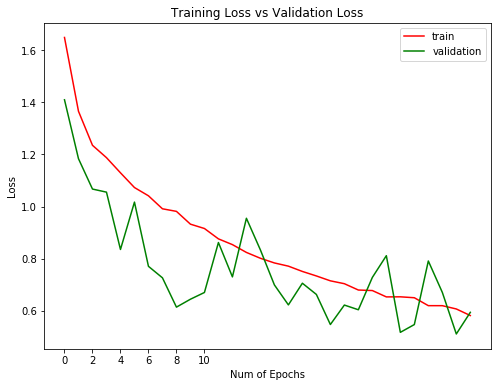

In [34]:
make_gorsel_3(Dropout_history)

In [ ]:
make_gorsel(Dropout_history .history," Dropout ")

In [36]:
model = make_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 128)        

In [37]:
train_gen,test_gen = make_generator(train_dir,test_dir,augmentation=True)

Using real-time data augmentation.
Found 3000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [38]:
Augmentation_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/30
60/60 [==============================] - 387s 6s/step - loss: 1.6205 - acc: 0.3370 - val_loss: 1.3010 - val_acc: 0.4750
Epoch 2/30
60/60 [==============================] - 503s 8s/step - loss: 1.3474 - acc: 0.4663 - val_loss: 1.1868 - val_acc: 0.5117
Epoch 3/30
60/60 [==============================] - 472s 8s/step - loss: 1.2499 - acc: 0.5187 - val_loss: 1.0736 - val_acc: 0.5400
Epoch 4/30
60/60 [==============================] - 272s 5s/step - loss: 1.1937 - acc: 0.5443 - val_loss: 1.0603 - val_acc: 0.5833
Epoch 5/30
60/60 [==============================] - 237s 4s/step - loss: 1.1370 - acc: 0.5633 - val_loss: 0.9094 - val_acc: 0.6517
Epoch 6/30
60/60 [==============================] - 234s 4s/step - loss: 1.0816 - acc: 0.5907 - val_loss: 1.2036 - val_acc: 0.6117
Epoch 7/30
60/60 [==============================] - 234s 4s/step - loss: 1.0483 - acc: 0.6160 - val_loss: 0.9335 - val_acc: 0.6700
Epoch 8/30
60/60 [==============================] - 232s 4s/step - loss: 1.0177 - a

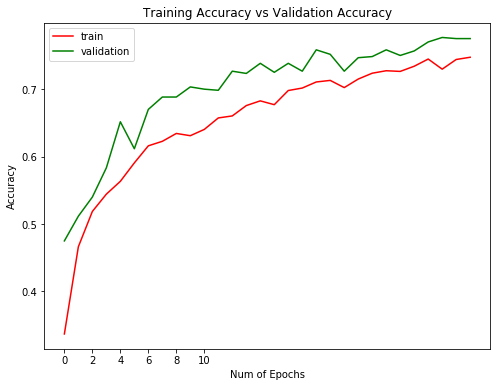

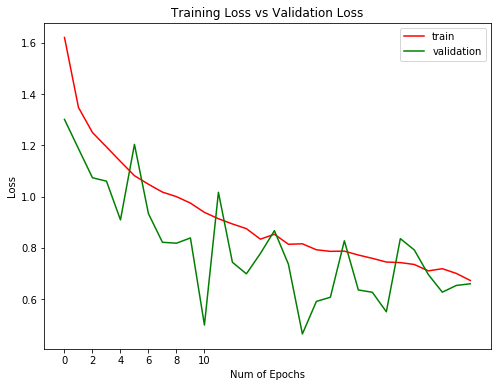

In [39]:
make_gorsel_3(Augmentation_history)

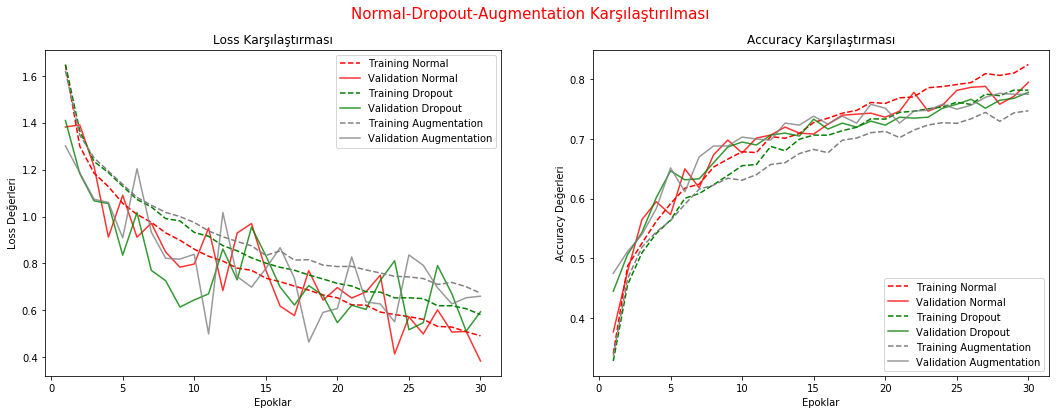

In [74]:
History_listesi = [historyNormal.history,Dropout_history.history,Augmentation_history.history]
Historiler = ["Normal","Dropout","Augmentation"]
make_gorsel_2(History_listesi,Historiler)

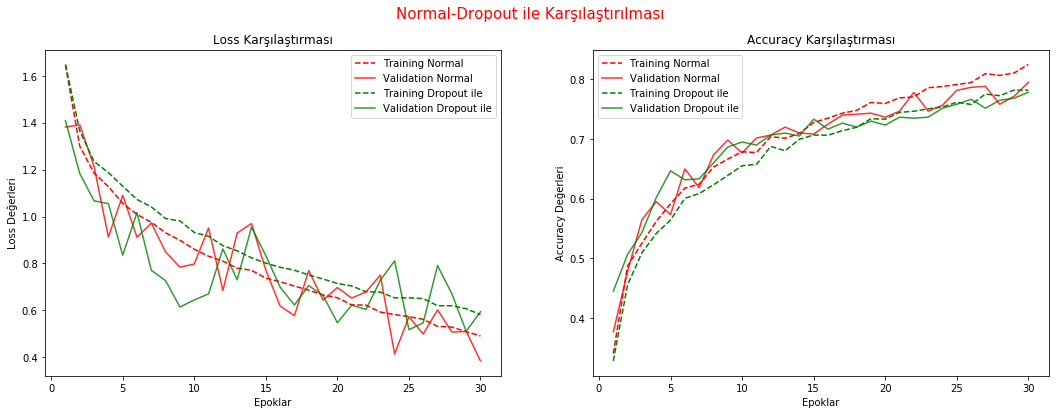

In [75]:
History_listesi = [historyNormal.history,Dropout_history.history]
Historiler = ["Normal","Dropout ile",]
make_gorsel_2(History_listesi,Historiler)

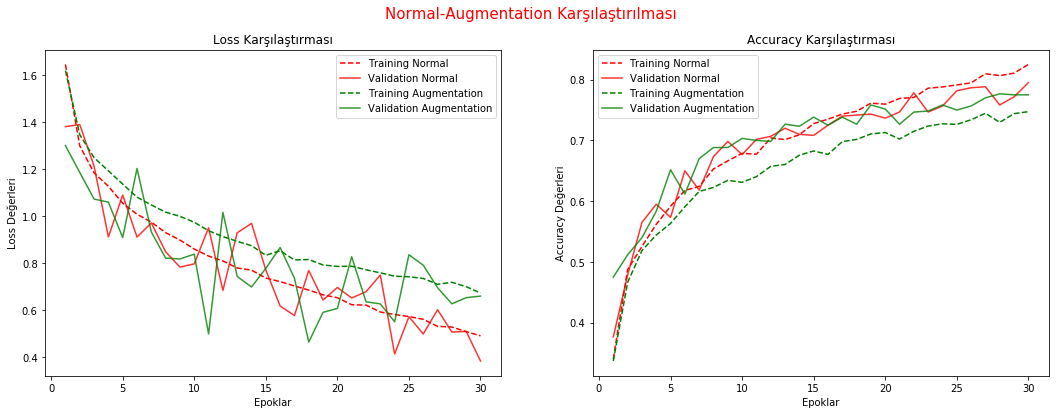

In [76]:
History_listesi = [historyNormal.history,Augmentation_history.history]
Historiler = ["Normal","Augmentation"]
make_gorsel_2(History_listesi,Historiler)

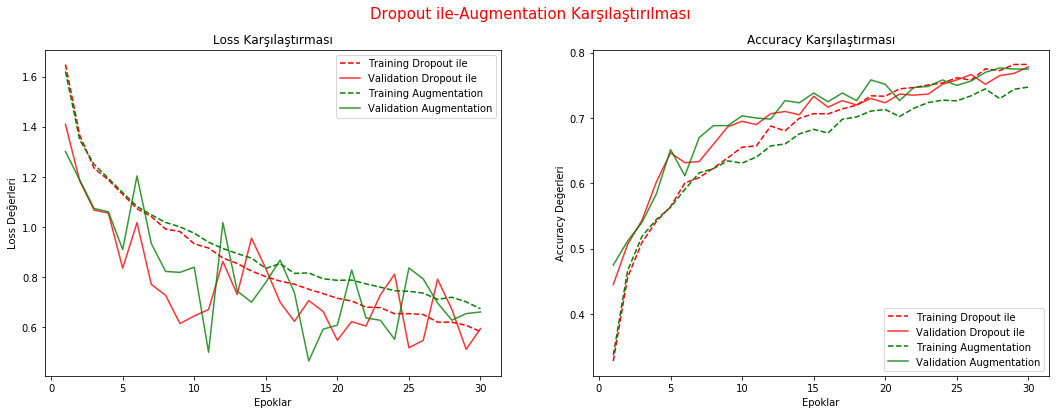

In [77]:
History_listesi = [Dropout_history.history,Augmentation_history.history]
Historiler  = ["Dropout ile","Augmentation"]
make_gorsel_2(History_listesi,Historiler )

In [70]:
MaxTrainAccuracy = [np.max(historyNormal.history["acc"]),
          np.max(Dropout_history.history["acc"]),
          np.max(Augmentation_history.history["acc"])]

MaxValidationAccuracy = [np.max(historyNormal.history["val_acc"]),
          np.max(Dropout_history.history["val_acc"]),
          np.max(Augmentation_history.history["val_acc"])]

x = np.arange(len(MaxTrainAccuracy))

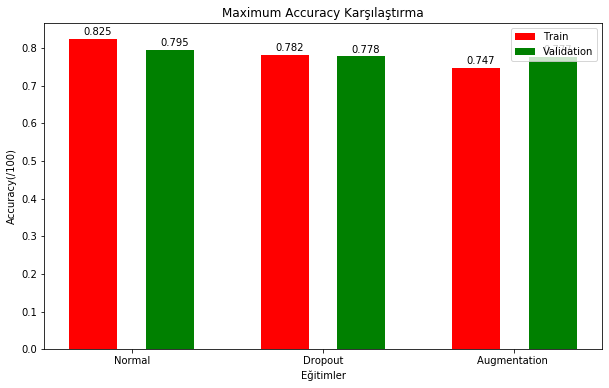

In [63]:
plt.figure(figsize=(10,6))

a = x-0.2
b = x+0.2
plt.bar(a,MaxTrainAccuracy,width=0.25,color="red")
plt.bar(b,MaxValidationAccuracy,width=0.25,color="green")

plt.xlabel("Eğitimler")
plt.xticks(x,["Normal","Dropout","Augmentation "])
plt.ylabel("Accuracy(/100)")
plt.title("Maximum Accuracy Karşılaştırma")

plt.legend(["Train","Validation"])

for i in range(len(x)):
    plt.text(a[i]-0.05,MaxTrainAccuracy[i]+0.01,str("{:.3f}".format(MaxTrainAccuracy[i])))
    plt.text(b[i]-0.05,MaxValidationAccuracy[i]+0.01,str("{:.3f}".format(MaxValidationAccuracy[i])))
    
plt.show()

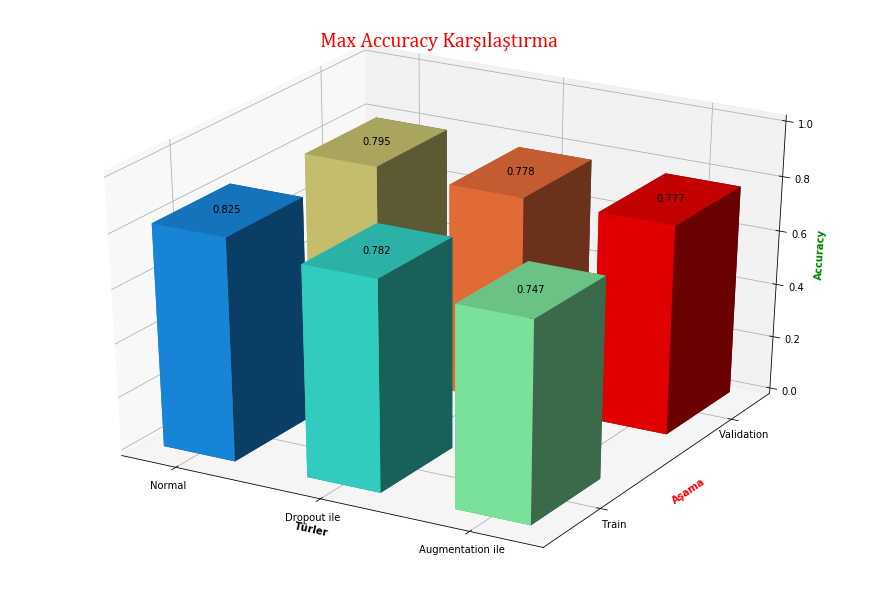

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

z = list()
z.append(MaxTrainAccuracy)
z.append(MaxValidationAccuracy)

acc = np.array(z,dtype=np.float)
sekil = plt.figure(figsize=(12,8))
ax = Axes3D(sekil)

xlabels = np.array(['Normal','Dropout ile','Augmentation ile'])
xpos = np.arange(xlabels.shape[0])
ylabels = np.array(['Train','Validation'])
ypos = np.arange(ylabels.shape[0])
a,b = np.meshgrid(xpos,ypos,copy=False)
zpos = acc
zpos = zpos.ravel()

dx=0.5;dy=0.5;dz=zpos

ax.w_xaxis.set_ticks(xpos+0.2)
ax.w_xaxis.set_ticklabels(xlabels)
ax.w_yaxis.set_ticks(ypos+0.3)
ax.w_yaxis.set_ticklabels(ylabels)

ax.set_zlim(0,1)

ax.xaxis.set_label_text("Türler",fontweight="bold",color="black")
ax.yaxis.set_label_text("Aşama",fontweight="bold",color="red")
ax.zaxis.set_label_text("Accuracy",fontweight="bold",color="green")

for i in xpos:
    for j in ypos:
        ax.text3D(i+0.2,j+0.2,acc[j,i],str("{:.3f}".format(acc[j,i])))
    
values = np.linspace(0.2,1.,a.ravel().shape[0])
renkler = cm.rainbow(values)
ax.bar3d(a.ravel(),b.ravel(),dz*0,dx,dy,dz,color=renkler)
plt.title( " Max Accuracy Karşılaştırma ",fontsize=20,fontname="Cambria",color="red")
plt.show()